# 해결해야할 문제들 목록

## 데이터 관련
- [ ] spectrogram 이외의 정보 (MFCC 등...)
- [ ] 데이터 정규화 이후 학습
- [x] 정규화 방법 찾음




## 학습 관련

- [x] loss가 줄어들지 않는 문제
- [x] 학습이 편향되는 문제 
  - 이미지에 붙는 padding이 문제였음
  




### CNN BASED Music Emotion Classification

# 1. 학습에 필요한 것들

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/sample'
test_data_path = '/content/drive/MyDrive/test'

Mounted at /content/drive


In [2]:
# Module Import 
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import soundfile as sf
import random


from glob import glob
from PIL import Image
from torch.utils.data import Dataset
from skimage import io
from torchvision.io import read_image

In [3]:
# Read csv file
def read_csv(csv_path):
  csv_path ='/content/drive/MyDrive/sample/Labels.csv'
  data_frame = pd.read_csv(csv_path)

  return data_frame


#data_frame.iloc[0]
#
#Name      Labels
#sample1     4
#sample2     4


In [4]:
# For wave image , wav files are transformed by stft 
# wav transform 
# default sampling rate : 22050

def makeSpectrogram(spectrogram_path):
  for idx,content in data_frame.iterrows():

    # Audio analyze using Librosa  
    wave,rate= librosa.load(data_path+"/"+content[0],sr=22050)
    stft_result = librosa.stft(wave)

    # complex variable function --> real variable function
    D = np.abs(stft_result)

    # change to mel scale
    melspectrogram = librosa.feature.melspectrogram(S=D)

    plt.imshow(melspectrogram)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left=0,bottom=0,right=1,top=1,hspace=0,wspace=0)

    # need spectrogram path 
    plt.savefig(data_path+"/spectrogram/"+content[0],bbox_inches='tight',pad_inches=0,dpi=100,format="png")

 

In [5]:
class CustomMusicDataset(Dataset):
  #transform = None / target_transform = None
  def __init__(self,labels_file,img_dir):

    # 파일 기준  
    self.img_labels = pd.read_csv(labels_file)
    self.img_dir = img_dir
    
  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx,0])
    
    image = Image.open(img_path,mode="r")
    re_img = image.resize((128,128))

    r,g,b,alpha= re_img.split()

    r_resize_img = np.float32(r) / 255.0
    g_resize_img = np.float32(g) / 255.0
    b_resize_img = np.float32(b) / 255.0

    rgb_resize_img = np.asarray([r_resize_img,g_resize_img,b_resize_img])
    label = self.img_labels.iloc[idx,1]

    sample = [rgb_resize_img,label]
    return sample



# 1 : netural  2: happy  3: sad

In [6]:
# path 설정
Labels ="/content/drive/MyDrive/sample/Labels.csv"
root = "/content/drive/MyDrive/sample/spectrogram"



trainset = CustomMusicDataset(Labels,root)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=1,shuffle=True)




In [7]:
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__()

        self.layer1 = self.conv_module(3,16)
        self.layer2 = self.conv_module(16,32)
        self.layer3 = self.conv_module(32,64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128,256)

        self.fc1 = nn.Linear(4096,120)
        self.fc2 = nn.Linear(120,80)
        self.fc3 = nn.Linear(80,3)
        
        

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      x = x.view(-1, 4096)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)

      return x

    def conv_module(self,in_num,out_num):
      return nn.Sequential(
          nn.Conv2d(in_num,out_num,kernel_size = 3, stride=1,padding = 1),
          nn.BatchNorm2d(out_num),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2)
      )


net = CustomConvNet().cuda()


In [8]:
def training():

  cuda = torch.device('cuda')
  criterion = nn.CrossEntropyLoss()
  
  if torch.cuda.is_available():
    criterion = nn.CrossEntropyLoss().cuda()
    
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(30):
      running_loss = 0.0

      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data

          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()

          if i%399 == 398:

            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 399))

            running_loss = 0.0

  print('Finished Training')

In [9]:
# Model Save
PATH = './net.pth'
torch.save(net.state_dict(),PATH)

In [10]:
# 
path = "/content/drive/MyDrive/test"
content_list = glob(path+"/*.wav")
print(content_list)
test_music = os.listdir(path)

['/content/drive/MyDrive/test/OMFG - Hello.wav', '/content/drive/MyDrive/test/Pentatonix.wav', '/content/drive/MyDrive/test/Animals.wav', '/content/drive/MyDrive/test/Sing Me To Sleep.wav', '/content/drive/MyDrive/test/Never Gonna Give You Up.wav', '/content/drive/MyDrive/test/Lean On.wav', '/content/drive/MyDrive/test/Uptown Funk.wav', '/content/drive/MyDrive/test/Hero.wav', '/content/drive/MyDrive/test/Get Lucky.wav', '/content/drive/MyDrive/test/The Next Episode.wav', '/content/drive/MyDrive/test/CHEER UP.wav', '/content/drive/MyDrive/test/Spectre.wav', '/content/drive/MyDrive/test/Scream & Shout.wav', '/content/drive/MyDrive/test/We Dem Boyz.wav', '/content/drive/MyDrive/test/Stay The Night.wav', '/content/drive/MyDrive/test/Outside.wav', '/content/drive/MyDrive/test/Starset.wav', '/content/drive/MyDrive/test/Dum Dee Dum.wav', '/content/drive/MyDrive/test/Crystallize.wav', "/content/drive/MyDrive/test/I'd Love to Change the World.wav"]


In [11]:
def new_music_analyze(path,file_name):
  folder_path = path+"/"+file_name+"_sample"
  os.mkdir(folder_path)
  data,rate = librosa.load(path+"/"+file_name)
  
  seconds = len(data)//22050
  five_sec_chunck = seconds // 5
  

  for i in range(five_sec_chunck-1):
    wave = data[rate*5*i:rate*5*(i+1)]
    stft_result = librosa.stft(wave)
    D = np.abs(stft_result)
    melspectrogram = librosa.feature.melspectrogram(S=D)

    plt.imshow(melspectrogram)
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.subplots_adjust(left=0,bottom=0,right=1,top=1,hspace=0,wspace=0)

    plt.savefig(folder_path+"/"+file_name+"_"+str(i),pad_inches=0,dpi=100,format="png",bbox_inches="tight")



  
  
    





    


In [12]:
print(test_music)

['OMFG - Hello.wav', 'Pentatonix.wav', 'Animals.wav', 'Sing Me To Sleep.wav', 'Never Gonna Give You Up.wav', 'Lean On.wav', 'Uptown Funk.wav', 'Hero.wav', 'Get Lucky.wav', 'The Next Episode.wav', 'CHEER UP.wav', 'Spectre.wav', 'Scream & Shout.wav', 'We Dem Boyz.wav', 'Stay The Night.wav', 'Outside.wav', 'Starset.wav', 'Dum Dee Dum.wav', 'Crystallize.wav', "I'd Love to Change the World.wav", 'test_result.csv', 'OMFG - Hello.wav_sample', 'Pentatonix.wav_sample', 'Sing Me To Sleep.wav_sample', 'Never Gonna Give You Up.wav_sample', "I'd Love to Change the World.wav_sample", 'Darin-Autumn.WAV', 'Darin-Autumn.WAV_sample']


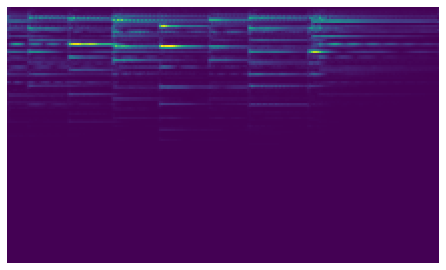

In [ ]:
new_music_analyze(path,test_music[-1])

In [13]:
test_label = "/content/drive/MyDrive/test/Darin-Autumn.WAV_sample/test_label.csv"
test_root = "/content/drive/MyDrive/test/Darin-Autumn.WAV_sample"

testset = CustomMusicDataset(test_label,test_root)
testloader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

# cross validation -- sklearn NeuralNetClassifier



In [14]:
dataiter = iter(testloader)
counter = {0:0,1:0,2:0}
for idx,i in enumerate(dataiter,0):
  images,labels = i
  images = images.cuda()
  labels = labels.cuda()
  outputs=net(images)
  
  _,predicted = torch.max(outputs,1)
  print(predicted)
  
  if predicted[0] == 0:
    counter[0] += 1
  elif predicted[0] == 1:
    counter[1] += 1
  else:
    counter[2] += 1

classes = ("차분한 노래","신나는 노래","슬픈 노래")
print(counter)
max_list = list(counter.items())
max_list.sort(key=lambda x:x[1])
print(classes[max_list[-1][0]])

tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([1], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([1], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([1], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], device='cuda:0')
tensor([2], de